In [1]:
# Importing libraries
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Importing the needed datasets
crime_rate = pd.read_csv("./work/2022-23d-1fcmgt-reg-ai-01-group-team3/data/Misdrijven_per_wijk_en_buurt_per_maand_15052023_134652.csv", sep=";")
df_educational_level = pd.read_csv("./work/2022-23d-1fcmgt-reg-ai-01-group-team3/data/processed/educational_level_neighbourhood_of_Gemeente_Breda_processed.csv", sep=",")
df_income_level = pd.read_csv("./work/2022-23d-1fcmgt-reg-ai-01-group-team3/data/processed/income_level_neighbourhood_of_Gemeente_Breda_processed.csv", sep=",")
df_qol_of_Breda = pd.read_csv('./work/2022-23d-1fcmgt-reg-ai-01-group-team3/data/processed/QOL_of_Gemeente_Breda_processed.csv')
df_region = gpd.read_file('./work/2022-23d-1fcmgt-reg-ai-01-group-team3/data/Buurten.geojson')

In [3]:
# splitting 'Perioden' into 'Year' and 'month' column
crime_rate['Year'] = crime_rate['Perioden'].str.split(' ').str[0]
crime_rate['month'] = crime_rate['Perioden'].str.split(' ').str[1]
# removing the 'Perioden' column
del crime_rate['Perioden']
crime_rate

,Soort misdrijf,Wijken en buurten,Geregistreerde misdrijven (aantal),Year,month
0,Totaal misdrijven,Breda centrum,370.0,2012,januari
1,Totaal misdrijven,Breda centrum,401.0,2012,februari
2,Totaal misdrijven,Breda centrum,375.0,2012,maart
3,Totaal misdrijven,Breda centrum,370.0,2012,april
4,Totaal misdrijven,Breda centrum,436.0,2012,mei
...,...,...,...,...,...
537603,3.9.3 Fraude (overig),Buitengebied Teteringen,0.0,2022,december
537604,3.9.3 Fraude (overig),Buitengebied Teteringen,0.0,2023,januari
537605,3.9.3 Fraude (overig),Buitengebied Teteringen,0.0,2023,februari
537606,3.9.3 Fraude (overig),Buitengebied Teteringen,0.0,2023,maart


In [4]:
# Filtering the neighbourhoods
def neighborhoods_mask(data, column):
    
    neighborhoods = ['Bavel', 'Belcrum', 'Biesdonk', 'Blauwe Kei', 'Boeimeer',
           'Brabantpark', 'Buitengebied Bavel', 'Buitengebied Prinsenbeek',
           'Buitengebied Ulvenhout', 'Chassé', 'City', 'Doornbos-Linie',
           'Effen-Rith', 'Fellenoord', 'Gageldonk', 'Geeren-noord',
           'Geeren-zuid', 'Ginneken', 'Haagpoort', 'Heilaar', 'Heksenwiel',
           'Heusdenhout', 'Heuvel', 'Kesteren', 'Kievitsloop', 'Kroeten',
           'Krogten', 'Liesbos', 'Mastbos', 'Muizenberg', 'Nieuw Wolfslaar',
           'Overakker', 'Overkroeten', 'Princenhage', 'Prinsenbeek',
           'Ruitersbos', 'Schorsmolen', 'Sportpark', 'Station', 'Steenakker',
           'Teteringen', 'Tuinzigt', 'Ulvenhout', 'Valkenberg', 'Waterdonken',
           'Westerpark', 'Wisselaar', 'Ypelaar', 'Zandberg']
    
    
    mask = data[column].isin(neighborhoods)
    data = data[mask]
    return data

crime_rate = neighborhoods_mask(crime_rate, 'Wijken en buurten')

In [5]:
# Filtering to only the total crimes
crime_rate = crime_rate[crime_rate['Soort misdrijf'] == 'Totaal misdrijven']
# Renaming the column from 'Wijken en buurten' to 'buurten'
crime_rate = crime_rate.rename(columns = {'Wijken en buurten':'buurten'})
# Aggregating the crime rate for 'Year' and 'buurten'
crime_rate_year = crime_rate.groupby(['Year', 'buurten'], as_index=False)[['Geregistreerde misdrijven (aantal)']].sum()

In [6]:
# Converting the neighbourhoods labels into integers
le = LabelEncoder()
crime_rate_year['buurten'] = le.fit_transform(crime_rate_year['buurten'])
crime_rate_year = pd.DataFrame(crime_rate_year, columns=crime_rate_year.columns)
buurten = crime_rate_year['buurten']

In [7]:
crime_rate_year

,Year,buurten,Geregistreerde misdrijven (aantal)
0,2012,0,605.0
1,2012,1,277.0
2,2012,2,470.0
3,2012,3,208.0
4,2012,4,511.0
...,...,...,...
583,2023,44,7.0
584,2023,45,28.0
585,2023,46,50.0
586,2023,47,88.0


In [8]:
# Defining the model
km = KMeans(n_clusters=2, random_state=0, n_init='auto')

In [9]:
# Taking the unique values of 'Year'
years = crime_rate_year['Year'].unique()

# Creating dataframe to store the results of the clustering model
dataframe_predictions = pd.DataFrame(columns=years)

# The labels for each clusters
cluster_labels = ['Low Crime', 'High Crime']

# Looping through each year, so it can put labels for eaach of them
for year in years:

    # Subsetting to specific year
    crime_rate_year_temp = crime_rate_year[crime_rate_year['Year'] == year].copy()

    # checks whether the dataframe is empty
    if not crime_rate_year_temp.empty:
        # Train and predict the model
        clusters = km.fit_predict(crime_rate_year_temp)
        # Put the clusters in a dataframe
        dataframe_predictions[year] = clusters
        # Put the respective labels
        dataframe_predictions[year] = [cluster_labels[cluster] for cluster in clusters]

        # Insert data into the dataframe
        if year not in dataframe_predictions.columns:
            dataframe_predictions.insert(0, year)
            
# Putting the neighbourhoods in the dataframe
dataframe_predictions['neighborhoods'] = buurten

In [10]:
# Converting to the previous values of neighbourhoods
dataframe_predictions['neighborhoods'] = le.inverse_transform(dataframe_predictions['neighborhoods'])
dataframe_predictions = dataframe_predictions.set_index('neighborhoods')

In [11]:
dataframe_predictions

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
neighborhoods,,,,,,,,,,,,
Bavel,High Crime,Low Crime,Low Crime,High Crime,High Crime,High Crime,High Crime,Low Crime,High Crime,High Crime,High Crime,Low Crime
Belcrum,Low Crime,Low Crime,Low Crime,Low Crime,High Crime,High Crime,High Crime,High Crime,High Crime,High Crime,High Crime,High Crime
Biesdonk,Low Crime,Low Crime,Low Crime,High Crime,High Crime,High Crime,High Crime,High Crime,High Crime,High Crime,High Crime,High Crime
Blauwe Kei,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime
Boeimeer,Low Crime,Low Crime,Low Crime,Low Crime,High Crime,High Crime,Low Crime,Low Crime,High Crime,High Crime,Low Crime,Low Crime
Brabantpark,High Crime,High Crime,High Crime,High Crime,High Crime,High Crime,High Crime,High Crime,High Crime,High Crime,High Crime,High Crime
Buitengebied Bavel,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime
Buitengebied Prinsenbeek,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime
Buitengebied Ulvenhout,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime,Low Crime


In [12]:
# Taking the labels for 2020
crime_predictions_2020 = dataframe_predictions['2020']

In [13]:
df_educational_level['Buurten'].unique()

array(['Valkenberg', 'Chassé', 'Fellenoord', 'Schorsmolen', 'Station',
       'City', 'Belcrum', 'Doornbos-Linie', 'Biesdonk', 'Geeren-zuid',
       'Wisselaar', 'Krogten', 'Geeren-noord', 'Waterdonken',
       'Brabantpark', 'Sportpark', 'Zandberg', 'Heusdenhout',
       'Moleneind-oost', 'Hoogeind', 'Blauwe Kei', 'Ypelaar', 'Overakker',
       'Ginneken', 'Mastbos', 'Boeimeer', 'Ruitersbos', 'Haagpoort',
       'Heuvel', 'Tuinzigt', 'Princenhage', 'Westerpark', 'Heilaar',
       'Hazeldonk', 'Steenakker', 'Effen-Rith', 'Liesbos', 'Gageldonk',
       'Kievitsloop', 'Kesteren', 'Muizenberg', 'Heksenwiel',
       'Overkroeten', 'Kroeten', 'Emer', 'Hagebeemd', 'Bavel',
       'Nieuw Wolfslaar', 'Buitengebied Bavel', 'Ulvenhout',
       'Buitengebied Ulvenhout', 'Prinsenbeek',
       'Buitengebied Prinsenbeek', 'Teteringen', 'Vuchtpolder',
       'Buitengebied Teteringen'], dtype=object)

In [14]:
df_income_level['Buurten'].unique()

array(['Valkenberg', 'Chassé', 'Fellenoord', 'Schorsmolen', 'Station',
       'City', 'Belcrum', 'Doornbos-Linie', 'Biesdonk', 'Geeren-zuid',
       'Wisselaar', 'Krogten', 'Geeren-noord', 'Waterdonken',
       'Brabantpark', 'Sportpark', 'Zandberg', 'Heusdenhout',
       'Moleneind-oost', 'Hoogeind', 'Blauwe Kei', 'Ypelaar', 'Overakker',
       'Ginneken', 'Mastbos', 'Boeimeer', 'Ruitersbos', 'Haagpoort',
       'Heuvel', 'Tuinzigt', 'Princenhage', 'Westerpark', 'Heilaar',
       'Hazeldonk', 'Steenakker', 'Effen-Rith', 'Liesbos', 'Gageldonk',
       'Kievitsloop', 'Kesteren', 'Muizenberg', 'Heksenwiel',
       'Overkroeten', 'Kroeten', 'Emer', 'Hagebeemd', 'Bavel',
       'Nieuw Wolfslaar', 'Buitengebied Bavel', 'Ulvenhout',
       'Buitengebied Ulvenhout', 'Prinsenbeek',
       'Buitengebied Prinsenbeek', 'Teteringen', 'Vuchtpolder',
       'Buitengebied Teteringen'], dtype=object)

In [15]:
df_qol_of_Breda['Buurten'].unique()

array(['Valkenberg', 'Chassé', 'Fellenoord', 'Schorsmolen', 'Station',
       'City', 'Belcrum', 'Doornbos-Linie', 'Biesdonk', 'Geeren-zuid',
       'Wisselaar', 'Krogten', 'Geeren-noord', 'Waterdonken',
       'Brabantpark', 'Sportpark', 'Zandberg', 'Heusdenhout',
       'Moleneind-oost', 'Hoogeind', 'Blauwe Kei', 'Ypelaar', 'Overakker',
       'Ginneken', 'Mastbos', 'Boeimeer', 'Ruitersbos', 'Haagpoort',
       'Heuvel', 'Tuinzigt', 'Princenhage', 'Westerpark', 'Heilaar',
       'Hazeldonk', 'Steenakker', 'Effen-Rith', 'Liesbos', 'Gageldonk',
       'Kievitsloop', 'Kesteren', 'Muizenberg', 'Heksenwiel',
       'Overkroeten', 'Kroeten', 'Emer', 'Hagebeemd', 'Bavel',
       'Nieuw Wolfslaar', 'Buitengebied Bavel', 'Ulvenhout',
       'Buitengebied Ulvenhout', 'Prinsenbeek',
       'Buitengebied Prinsenbeek', 'Teteringen', 'Vuchtpolder',
       'Buitengebied Teteringen'], dtype=object)

In [16]:
df_educational_level.columns

Index(['Unnamed: 0', 'Buurten', 'level_of_education', 'Year', 'value'], dtype='object')

In [17]:
df_educational_level = df_educational_level.drop('Unnamed: 0', axis=1)

In [18]:
# Subsetting the data to 2020
df_educational_level_year = df_educational_level[df_educational_level['Year'] == 2020]

# Convert the categorical column 'level_of_education' to three new columns
df_educational_level_year = (df_educational_level_year.pivot(index='Buurten', columns='level_of_education')
                                            .stack(level=0)
                                            .rename_axis(index=['Buurten', 'Year'], columns=None)
                                            ).reset_index()
# Dropping the unnecessary columns
df_educational_level_year = df_educational_level_year[df_educational_level_year['Year'] != 'Year']
df_educational_level_year = df_educational_level_year.drop(['Year', ' Midden'], axis=1)

In [19]:
df_income_level = df_income_level.drop('Unnamed: 0', axis=1)

In [20]:
# Subsetting the data to 2020
df_income_level_year = df_income_level[df_income_level['Year'] == 2020]

# Convert the categorical column 'level_of_income' to two new columns
df_income_level_year = (df_income_level_year.pivot(index='Buurten', columns='level_of_income')
                                            .stack(level=0)
                                            .rename_axis(index=['Buurten', 'Year'], columns=None)
                                            ).reset_index()

# Dropping the unnecessary columns
df_income_level_year = df_income_level_year[df_income_level_year['Year'] != 'Year']
df_income_level_year = df_income_level_year.drop('Year', axis=1)

In [21]:
df_income_level_year

,Buurten,High income,Low income
1,Bavel,"32,0","26,0"
3,Belcrum,"27,0","36,0"
5,Biesdonk,"7,0","55,0"
7,Blauwe Kei,"27,0","29,0"
9,Boeimeer,"31,0","33,0"
11,Brabantpark,"12,0","55,0"
13,Buitengebied Bavel,"57,0","14,0"
15,Buitengebied Prinsenbeek,"47,0","18,0"
17,Buitengebied Teteringen,?,?
19,Buitengebied Ulvenhout,"39,0","24,0"


In [22]:
df_qol_of_Breda = df_qol_of_Breda.drop('Unnamed: 0', axis=1)
df_qol_of_Breda_year = df_qol_of_Breda[df_qol_of_Breda['Year'] == 2020]

In [23]:
df_qol_of_Breda_year

,Buurten,Year,value
112,Valkenberg,2020,"4,1224382"
113,Chassé,2020,"4,2117509"
114,Fellenoord,2020,"3,9870623"
115,Schorsmolen,2020,"3,9446339"
116,Station,2020,"4,0620225"
117,City,2020,"4,1370920"
118,Belcrum,2020,"4,0524916"
119,Doornbos-Linie,2020,"3,9201641"
120,Biesdonk,2020,"3,8748954"
121,Geeren-zuid,2020,"3,8424682"


In [24]:
# Merging the data together
Breda_2020 = pd.merge(df_educational_level_year, df_income_level_year, on='Buurten')
Breda_2020 = pd.merge(Breda_2020, df_qol_of_Breda_year, on='Buurten')

In [25]:
Breda_2020.columns

Index(['Buurten', ' Hoog', ' Laag', ' High income', ' Low income', 'Year',
       'value'],
      dtype='object')

In [26]:
# Filtering the data to the rows with the missing values
Breda_2020_missing = Breda_2020[Breda_2020[' High income'] == '?']
# Filtering the data to the rows without the missing values
Breda_2020 = Breda_2020[Breda_2020[' High income'] != '?']

In [27]:
Breda_2020_missing

,Buurten,Hoog,Laag,High income,Low income,Year,value
8,Buitengebied Teteringen,50,60,?,?,2020,"4,4683443"
14,Emer,?,?,?,?,2020,?
21,Hagebeemd,90,40,?,?,2020,"4,3401180"
22,Hazeldonk,?,?,?,?,2020,?
27,Hoogeind,0,10,?,?,2020,?
34,Moleneind-oost,30,0,?,?,2020,?
50,Vuchtpolder,10,30,?,?,2020,"4,3157208"


In [28]:
Breda_2020 = Breda_2020.drop('Year', axis=1)

In [29]:
columns = [' High income', ' Low income', 'value']

# Replacing the ',' with '.' and converting the columns into float
for column in columns:
    Breda_2020[column] = Breda_2020[column].str.replace(',', '.').astype(float)

# Renaming the columns in English
Breda_2020 = Breda_2020.rename(columns={'Buurten': 'neighborhoods',
                                        ' Hoog': 'high_education',
                                        ' Laag': 'low_education',
                                        ' High income': 'high_income',
                                        ' Low income': 'low_income',
                                        'value': 'livability_index'})

In [30]:
Breda_2020

,neighborhoods,high_education,low_education,high_income,low_income,livability_index
0,Bavel,1520,810,32.0,26.0,4.228658
1,Belcrum,1580,520,27.0,36.0,4.052492
2,Biesdonk,720,1480,7.0,55.0,3.874895
3,Blauwe Kei,1310,590,27.0,29.0,4.234816
4,Boeimeer,2360,640,31.0,33.0,4.230117
5,Brabantpark,2880,1950,12.0,55.0,4.124997
6,Buitengebied Bavel,190,100,57.0,14.0,4.293419
7,Buitengebied Prinsenbeek,200,120,47.0,18.0,4.274724
9,Buitengebied Ulvenhout,80,40,39.0,24.0,4.247617
10,Chassé,1870,230,18.0,46.0,4.211751


In [31]:
# Converting to inegers
Breda_2020['high_education'] = Breda_2020['high_education'].astype(int)
Breda_2020['low_education'] = Breda_2020['low_education'].astype(int)

In [32]:
Breda_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49 entries, 0 to 55
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   neighborhoods     49 non-null     object 
 1   high_education    49 non-null     int64  
 2   low_education     49 non-null     int64  
 3   high_income       49 non-null     float64
 4   low_income        49 non-null     float64
 5   livability_index  49 non-null     float64
dtypes: float64(3), int64(2), object(1)
memory usage: 2.7+ KB


In [33]:
# Correlation matrix for the data
def correlation_matrix(data):

    # Taking only the numeric data from the dataset
    numeric_data = data.select_dtypes(include=np.number)

    # Defining the correlation matrix
    corr_matrix = numeric_data.corr(method='pearson')

    # Creating the figure for the matrix
    fig, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(corr_matrix,
               mask=np.triu(corr_matrix),
               ax=ax, annot=True).set_title(f'pearson correlation')

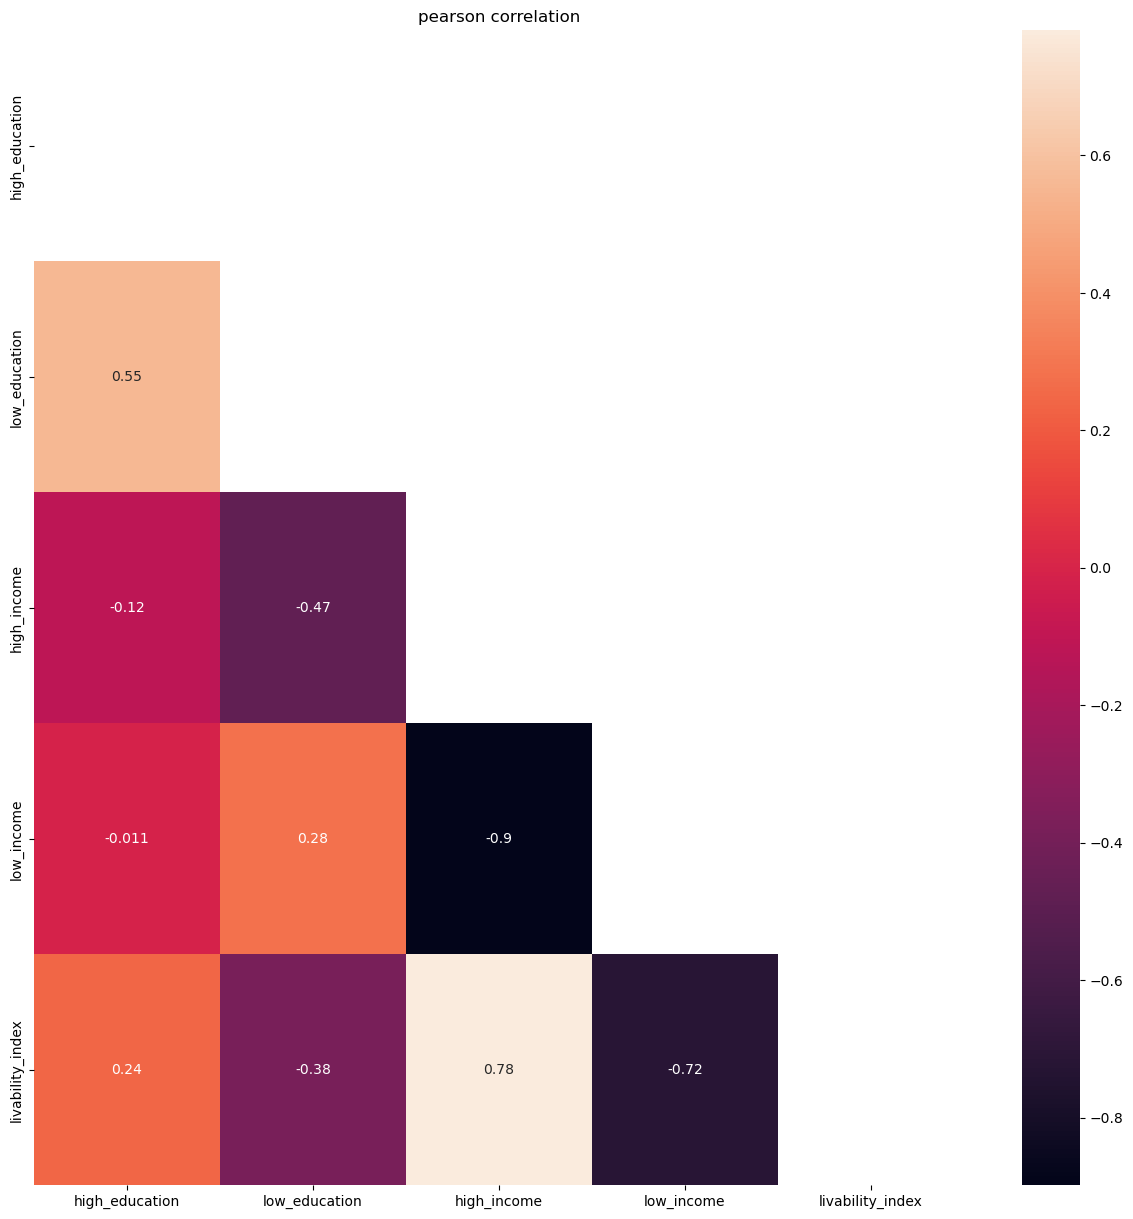

In [34]:
correlation_matrix(Breda_2020)

In [35]:
crime_rate['buurten'].sort_values().unique()

array(['Bavel', 'Belcrum', 'Biesdonk', 'Blauwe Kei', 'Boeimeer',
       'Brabantpark', 'Buitengebied Bavel', 'Buitengebied Prinsenbeek',
       'Buitengebied Ulvenhout', 'Chassé', 'City', 'Doornbos-Linie',
       'Effen-Rith', 'Fellenoord', 'Gageldonk', 'Geeren-noord',
       'Geeren-zuid', 'Ginneken', 'Haagpoort', 'Heilaar', 'Heksenwiel',
       'Heusdenhout', 'Heuvel', 'Kesteren', 'Kievitsloop', 'Kroeten',
       'Krogten', 'Liesbos', 'Mastbos', 'Muizenberg', 'Nieuw Wolfslaar',
       'Overakker', 'Overkroeten', 'Princenhage', 'Prinsenbeek',
       'Ruitersbos', 'Schorsmolen', 'Sportpark', 'Station', 'Steenakker',
       'Teteringen', 'Tuinzigt', 'Ulvenhout', 'Valkenberg', 'Waterdonken',
       'Westerpark', 'Wisselaar', 'Ypelaar', 'Zandberg'], dtype=object)

In [36]:
Breda_2020['neighborhoods'].unique()

array(['Bavel', 'Belcrum', 'Biesdonk', 'Blauwe Kei', 'Boeimeer',
       'Brabantpark', 'Buitengebied Bavel', 'Buitengebied Prinsenbeek',
       'Buitengebied Ulvenhout', 'Chassé', 'City', 'Doornbos-Linie',
       'Effen-Rith', 'Fellenoord', 'Gageldonk', 'Geeren-noord',
       'Geeren-zuid', 'Ginneken', 'Haagpoort', 'Heilaar', 'Heksenwiel',
       'Heusdenhout', 'Heuvel', 'Kesteren', 'Kievitsloop', 'Kroeten',
       'Krogten', 'Liesbos', 'Mastbos', 'Muizenberg', 'Nieuw Wolfslaar',
       'Overakker', 'Overkroeten', 'Princenhage', 'Prinsenbeek',
       'Ruitersbos', 'Schorsmolen', 'Sportpark', 'Station', 'Steenakker',
       'Teteringen', 'Tuinzigt', 'Ulvenhout', 'Valkenberg', 'Waterdonken',
       'Westerpark', 'Wisselaar', 'Ypelaar', 'Zandberg'], dtype=object)

In [37]:
# Filtering the neighbourhoods to the same
df_region = df_region[['BUURT', 'geometry']]

df_region = neighborhoods_mask(df_region, 'BUURT')

In [38]:
Breda_2020 = pd.merge(Breda_2020, df_region, left_on='neighborhoods', right_on='BUURT')

In [39]:
Breda_2020 = Breda_2020.drop('BUURT', axis=1)

In [40]:
Breda_2020.columns

Index(['neighborhoods', 'high_education', 'low_education', 'high_income',
       'low_income', 'livability_index', 'geometry'],
      dtype='object')

In [41]:
Breda_2020

,neighborhoods,high_education,low_education,high_income,low_income,livability_index,geometry
0,Bavel,1520,810,32.0,26.0,4.228658,"POLYGON ((4.83781 51.56766, 4.83759 51.56661, ..."
1,Belcrum,1580,520,27.0,36.0,4.052492,"POLYGON ((4.78190 51.59764, 4.78187 51.59728, ..."
2,Biesdonk,720,1480,7.0,55.0,3.874895,"POLYGON ((4.79155 51.60815, 4.79156 51.60813, ..."
3,Blauwe Kei,1310,590,27.0,29.0,4.234816,"POLYGON ((4.80149 51.57475, 4.80127 51.57461, ..."
4,Boeimeer,2360,640,31.0,33.0,4.230117,"POLYGON ((4.77733 51.58081, 4.77741 51.58051, ..."
5,Brabantpark,2880,1950,12.0,55.0,4.124997,"POLYGON ((4.81860 51.59364, 4.81828 51.59366, ..."
6,Buitengebied Bavel,190,100,57.0,14.0,4.293419,"POLYGON ((4.87119 51.56827, 4.87135 51.56790, ..."
7,Buitengebied Prinsenbeek,200,120,47.0,18.0,4.274724,"POLYGON ((4.71504 51.61456, 4.71637 51.61265, ..."
8,Buitengebied Ulvenhout,80,40,39.0,24.0,4.247617,"POLYGON ((4.79976 51.53723, 4.79953 51.53714, ..."
9,Chassé,1870,230,18.0,46.0,4.211751,"POLYGON ((4.78630 51.58690, 4.78298 51.58366, ..."


In [42]:
# Creating a geopandas dataframe so it can be plotted maps
Breda_2020 = gpd.GeoDataFrame(Breda_2020, geometry='geometry')

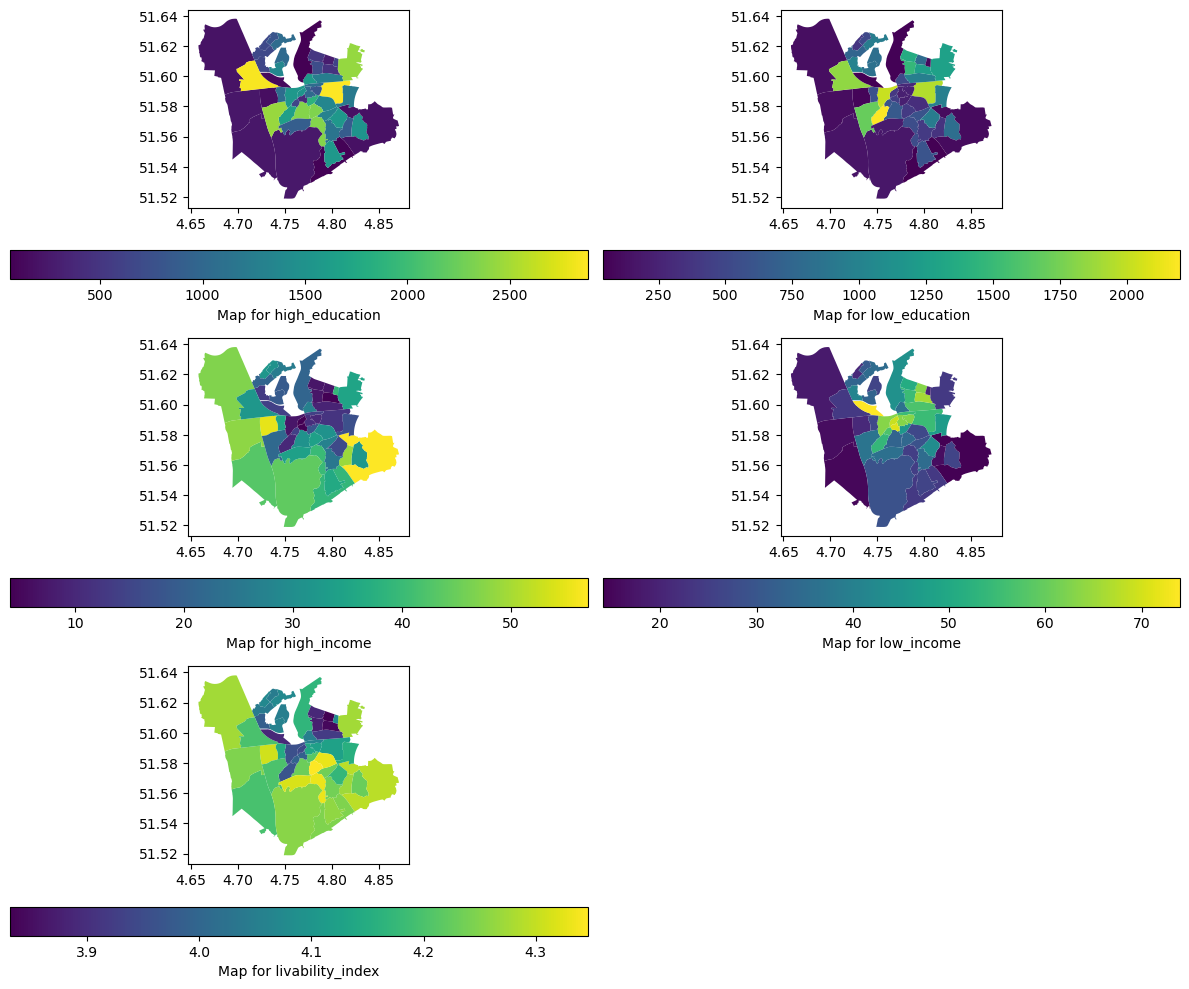

In [43]:
columns = ['high_education', 'low_education', 'high_income',
       'low_income', 'livability_index']

# Specifying the number of columns and rows for the vizualizations
num_subplots = len(columns)
num_cols = 2  
num_rows = (num_subplots + num_cols - 1) // num_cols

# Creating the figure and the axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))

# It helps for removing the unneccessary visualizations
num_empty_subplots = (num_rows * num_cols) - num_subplots

# Loops through all columns
for i, column in enumerate(columns):

    # It calculates the index for rows and columns
    row_index = i // num_cols
    col_index = i % num_cols

    # Creating plot for each column
    Breda_2020.plot(column=column,
                    legend=True, 
                    legend_kwds={"label": f'Map for {column}', "orientation": "horizontal"},
                    ax = axes[row_index][col_index])

# Check for empty visualizations
if num_empty_subplots > 0:
    for i in range(num_empty_subplots):
        fig.delaxes(axes[num_rows-1][num_cols-1-i])
        
# Plots the figure
plt.tight_layout()
plt.show()

In [44]:
# Breda_2020.to_csv('./work/2022-23d-1fcmgt-reg-ai-01-group-team3/data/Breda_2020.csv', index=False)

In [45]:
# Defining cross validation
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [46]:
# Separating features
X = Breda_2020.drop(['neighborhoods', 'geometry'], axis=1)
# Defining the Target Values
y = crime_predictions_2020

# Lists to store predictions, scores of the models and the models
accs = []
models = []
predictions = []
# Looping through all n_splits of the cross validation
for train_index, val_index in kf.split(X, y):

    # Splitting into training and validation data for feature
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    # Splitting into training and validation data for target values
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Defining a classfier
    knn = KNeighborsClassifier()
    # Training the model
    knn.fit(X_train, y_train)
    # Storing the models in a list
    models.append(knn)

for model in models:
    # Predicting the model
    y_pred = knn.predict(X_val)
    # Storing predictions
    predictions.append(y_pred)
    # Calculating the accuracy of the model
    acc = accuracy_score(y_val, y_pred)
    # Storing the results into a list
    accs.append(acc)
    
# The average of the accuracies
mean_acc = acc.mean()
print(mean_acc)

0.875


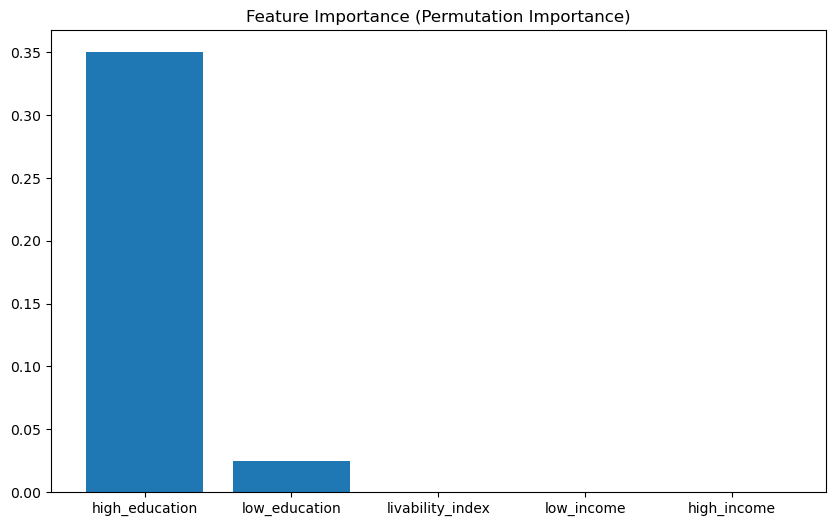

In [48]:
perm_importance = permutation_importance(knn, X_val, y_val, random_state=42)

# Getting the feature importances and their indices
importances = perm_importance.importances_mean
indices = np.argsort(importances)[::-1]

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Permutation Importance)")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices])
plt.show()